Analysis of the metadata metrics - age, completeness, number and types of links.

In [7]:
import pandas as pd


In [3]:
df = pd.read_csv('outputs/metadata_metrics.csv', sep='|', parse_dates=[1])

In [4]:
df[:10]


,source_url,metadata_age,protocol,has_lineage,has_quality,has_metadata,dataquality_wordcount,lineage_wordcount,online_distributions,offline_distributions,nondigital_distributions
0,http://ec.gc.ca/data_donnees/data/ice/conditio...,2011-07-21 00:00:00,"""FGDC""",True,True,True,242,75,0,0,0
1,http://geoport.whoi.edu/thredds/iso/MOBILE_BAY...,2015-08-12 00:00:00,"""ISO""",False,True,False,0,0,2,NaN,NaN
2,http://gisdata.nd.gov/Regional/RedRiverBasin/I...,2015-10-23 00:00:00,"""FGDC""",True,True,True,158,581,0,0,0
3,http://www.ncddc.noaa.gov/oer-waf/ISO/Resolved...,2014-10-23 00:00:00,"""ISO""",True,True,False,0,0,1,NaN,NaN
4,https://inport.nmfs.noaa.gov/inport/item/18471...,nan,"""ISO""",False,True,False,0,0,1,NaN,NaN
5,http://catalog.data.gov/harvest/object/7825bbf...,2011-09-28 00:00:00,"""ISO""",False,True,False,0,0,0,NaN,NaN
6,https://inport.nmfs.noaa.gov/inport/item/17844...,nan,"""ISO""",False,True,False,0,0,1,NaN,NaN
7,https://catalog.data.gov/harvest/object/bf64ed...,2006-05-17 00:00:00,"""ISO""",False,True,False,0,0,0,NaN,NaN
8,http://meta.geo.census.gov/data/existing/decen...,2013-06-15 00:00:00,"""ISO""",True,True,False,0,0,1,NaN,NaN
9,http://www.usgs.gov/science/xml.php?cite=2180,2012-09-04 00:00:00,"""FGDC""",False,False,True,0,0,0,0,0


In [1]:
%%html
<style>
table {float:left}
</style>

## Bag of Words Stats

We can only aggregate by data for ISO and FGDC. There's no equivalent date in OGC.

**Average number of tokens by protocol**

| Protocol   |  Average Token Count | 
|------------|----------------------| 
| FGDC       | 1740                 | 
| ISO        | 1292                 | 
| OGC        | 470                  | 
| OpenSearch | 218                  | 


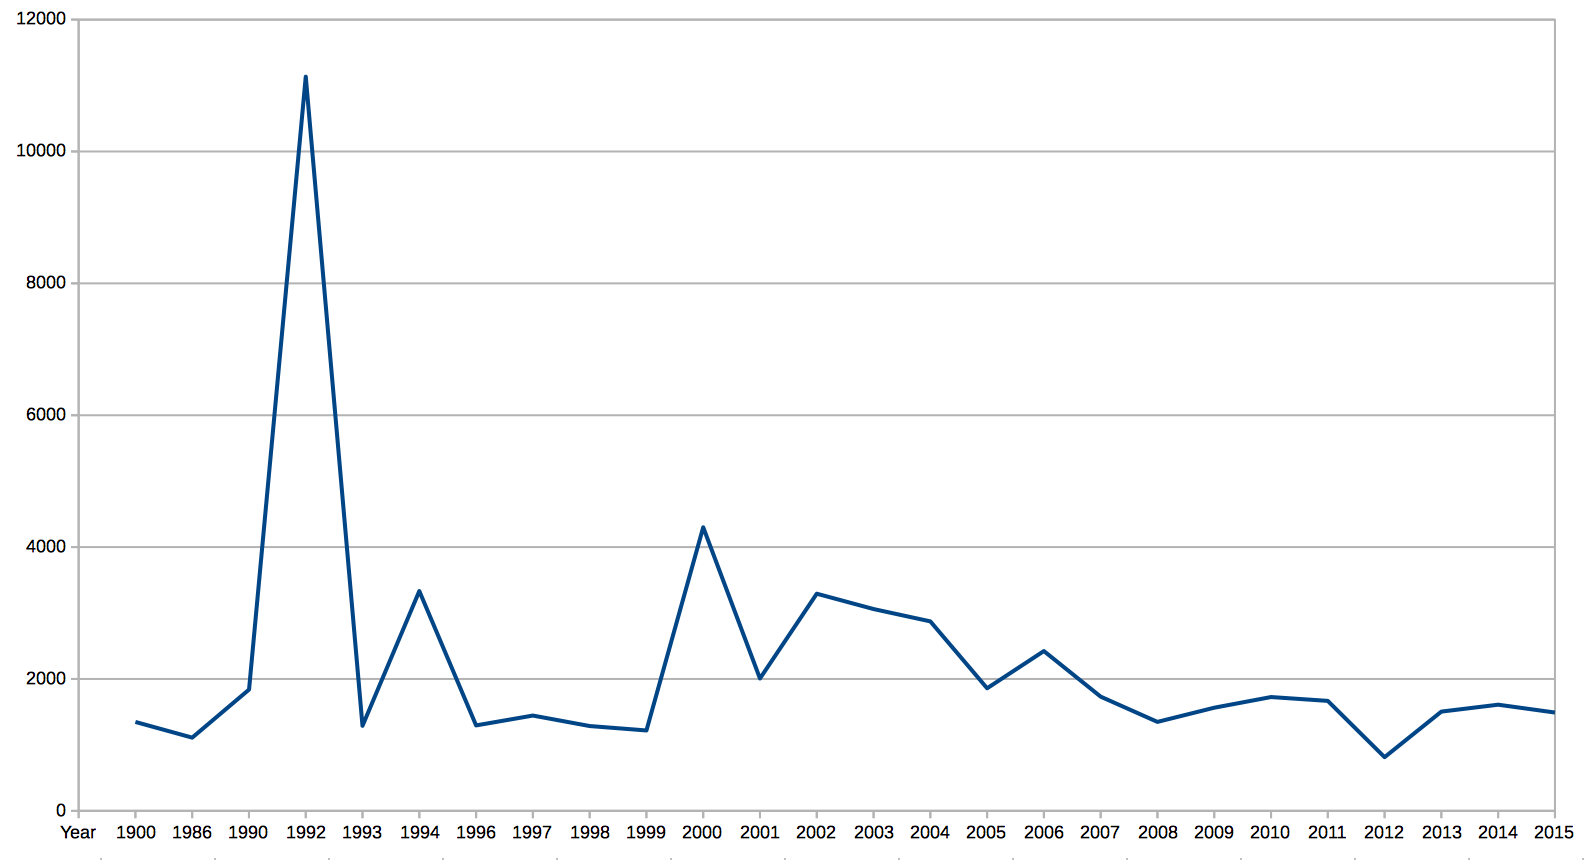

In [2]:
from IPython.display import Image
Image(filename='screenshots/iso_bow_year.png') 

# the image from libreoffice

# ISO tokens over time

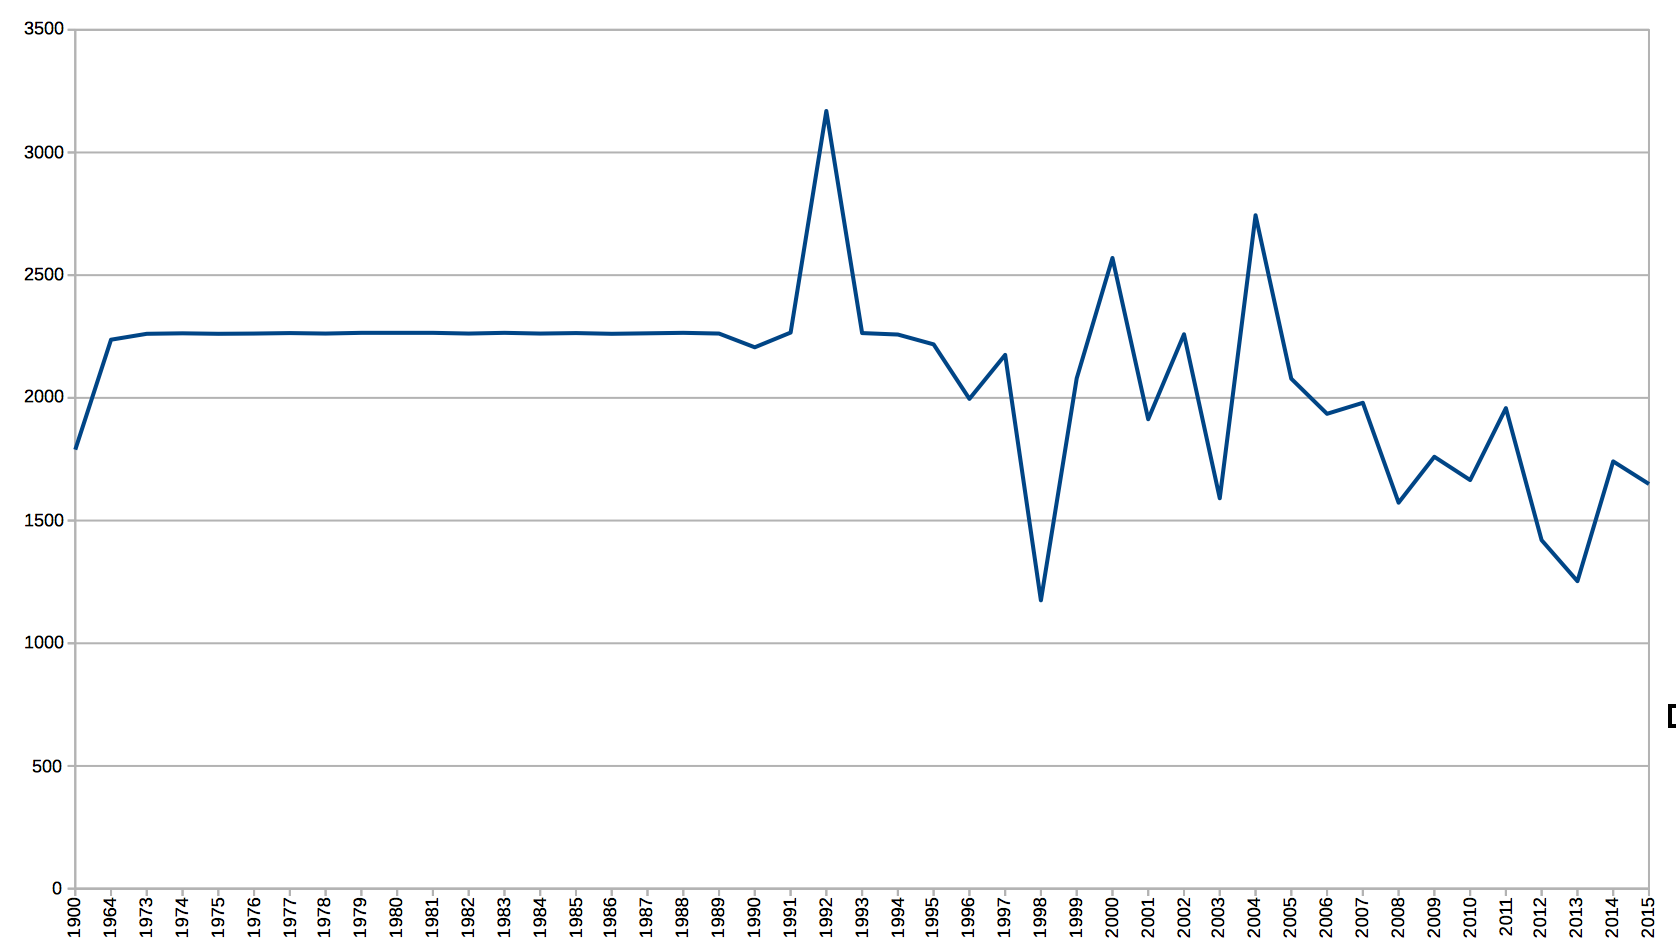

In [3]:
from IPython.display import Image
Image(filename='screenshots/fgdc_bow_year.png') 

# FGDC tokens over time

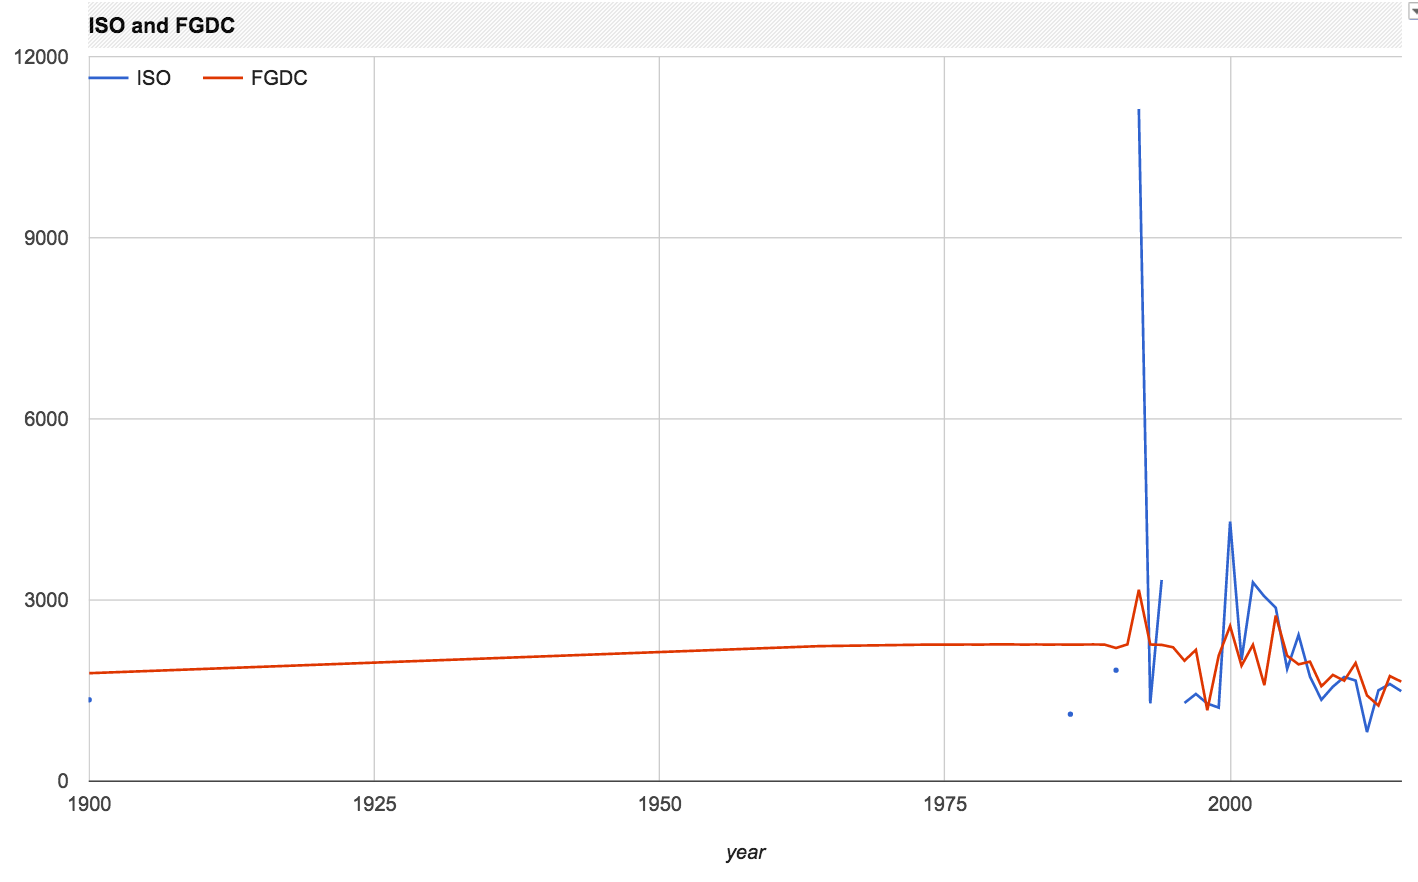

In [4]:
from IPython.display import Image
Image(filename='screenshots/fgdc_iso_bow_year.png') 

I think but can't really back it up with anything (seriously, we'd have to track down a bunch of metadata editors from the last twenty years) that metadata dates in ISO and FGDC are not always conceptually the same. Or at the very least, it is possibly the date the metadata record was written as FGDC or ISO, the date from the source metadata record (so the older key-value style text files) or possibly even the date it was emitted from the platform. I do wonder if that not-quite syncing up 2005 on is partly due to automation (the metadata as representation form a store that is either FGDC or ISO but came from row X in the database).

I didn't include the oddball years (ie the future!) although I will not that our future metadata seems to have a higher average token count. So good job, future selves!


So 1992 ISO. That is fantastic. Two LTER records from the same group with a big chunk of provenance and big chunks of data quality info. 

https://catalog.data.gov/harvest/object/8422d2e3-3d5f-4dbc-bca2-cf8a79f07c07

https://catalog.data.gov/harvest/object/b1e0689c-c08f-4e5b-9c76-11aa23b7d596

1992: what happens when people actually write metadata.

### A Table of Token Counts by Host

Can't have dates or identities here - we don't identify every possible XML thing and not many of those things have a date that *might* be related to the document. I am not considering the header timestamps here - that is related to the delivery of the content, not the internal specifics of the content (ie, I generated this xml on Tuesday and that is what the header reflects but the content was authored in 2012).

FYI: roughly 10K unique hosts identified with XML, only 1660 have more than 10 XML documents.

In [8]:
%matplotlib inline
import pandas as pd
import json as js  # name conflict with sqla
import sqlalchemy as sqla
from sqlalchemy.orm import sessionmaker

pd.set_option("display.max_rows",250)

# grab the clean text from the rds
with open('../local/big_rds.conf', 'r') as f:
    conf = js.loads(f.read())

# our connection
engine = sqla.create_engine(conf.get('connection'))

sql = """
select r.host, count(r.host) as records_per_host,
    avg(array_length(b.bag_of_words, 1))::int as avg_bow_size,
    min(array_length(b.bag_of_words, 1))::int as min_bow_size,
    max(array_length(b.bag_of_words, 1))::int as max_bow_size
from responses r join bags_of_words b on b.response_id = r.id
where r.host is not null and r.host != ''
group by r.host
having count(r.host) > 10
order by records_per_host desc;
"""

df = pd.read_sql(sql, engine)

In [9]:
df

,host,records_per_host,avg_bow_size,min_bow_size,max_bow_size
0,e4ftl01.cr.usgs.gov,55523,94,20,624
1,www.interieur.gouv.fr,51632,189,6,40550
2,findingaids.princeton.edu,25845,169,4,52955
3,disc2.nascom.nasa.gov,23054,312,16,6856
4,ngs.woc.noaa.gov,20660,26,1,20776
5,collections.nlm.nih.gov.libproxy.lib.unc.edu,19778,32,6,25289
6,academiccommons.columbia.edu,18328,197,17,6346
7,vho.nasa.gov,17157,76,1,10290
8,earthquake.usgs.gov,13222,2871,2,66845
9,opendata.euskadi.eus,12039,1029,1,62075
